## pip install tensorflow numpy matplotlib

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


In [18]:
class PINN(tf.keras.Model):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.dense_layers = [tf.keras.layers.Dense(width, activation=tf.nn.tanh)
                             for width in layers[:-1]]
        self.output_layer = tf.keras.layers.Dense(layers[-1], activation=None)

    def call(self, inputs):
        x = inputs
        for layer in self.dense_layers:
            x = layer(x)
        return self.output_layer(x)


In [25]:
def compute_loss_steady(model, inputs,mu):
    with tf.GradientTape(persistent=True) as tape:
        # Watch the input variables
        tape.watch(inputs)
        # Forward pass
        uvp = model(inputs)  # u, v, p predictions
        u, v, p = uvp[:, 0], uvp[:, 1], uvp[:, 2]
        
        # Prepare to calculate derivatives
        grads = tape.gradient(uvp, inputs)
        u_x, u_y = grads[:, 0], grads[:, 1]
        v_x, v_y = grads[:, 0], grads[:, 1]
        p_x, p_y = grads[:, 0], grads[:, 1]
        
        # Continuity equation for incompressibility
        continuity = u_x + v_y
        
        # Momentum equations for steady state, correct shapes and secondary derivatives
        u_xx = tape.gradient(u_x, inputs)[:, 0]
        u_yy = tape.gradient(u_y, inputs)[:, 1]
        v_xx = tape.gradient(v_x, inputs)[:, 0]
        v_yy = tape.gradient(v_y, inputs)[:, 1]

        momentum_u = u * u_x + v * u_y + p_x - mu * (u_xx + u_yy)
        momentum_v = u * v_x + v * v_y + p_y - mu * (v_xx + v_yy)
    
    # Mean squared error of residuals
    loss = tf.reduce_mean(continuity**2 + momentum_u**2 + momentum_v**2)
    del tape
    return loss

In [26]:
# Training function
def train_steady(model, inputs, epochs, mu):
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    loss_history = []  # to store loss values

    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            loss = compute_loss_steady(model, inputs, mu)
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        loss_history.append(loss.numpy())
        if epoch % 100 == 0:
            print(f"Epoch {epoch}: Loss: {loss.numpy()}")

    return loss_history

In [27]:
# Model and training parameters
layers = [3, 50, 50, 50, 3]  # Input layer, hidden layers, output layer (u, v, p)
mu = 0.001  # Viscosity, set appropriately for the fluid being modeled


In [28]:
# Initialize the model
model = PINN(layers,)

In [29]:
# Generate sample inputs (x, y, t for steady-state)
inputs = np.random.rand(1000, 3)  # 1000 random (x, y, t) points
inputs = tf.convert_to_tensor(inputs, dtype=tf.float32)



In [30]:
# Train the model
epochs = 1000
loss_history = train_steady(model, inputs, epochs, mu)



Epoch 0: Loss: 0.027524277567863464
Epoch 100: Loss: 2.9710179660469294e-05
Epoch 200: Loss: 1.030989642458735e-05
Epoch 300: Loss: 5.519138994714012e-06
Epoch 400: Loss: 3.033423126908019e-06
Epoch 500: Loss: 1.6831686480145436e-06
Epoch 600: Loss: 9.792023547561257e-07
Epoch 700: Loss: 6.277327315729053e-07
Epoch 800: Loss: 4.580962524869392e-07
Epoch 900: Loss: 3.75715188738468e-07


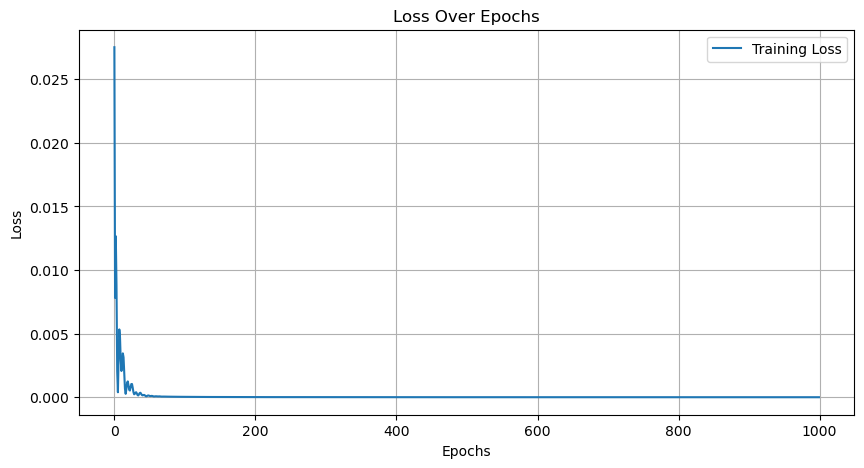

In [31]:
# Plot the loss over epochs
plt.figure(figsize=(10, 5))
plt.plot(loss_history, label='Training Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [33]:
# Define the spatial domain, adjust these as per your scenario
x_values = np.linspace(-1, 1, 100)  # X coordinates
y_values = np.linspace(-1, 1, 100)  # Y coordinates
X, Y = np.meshgrid(x_values, y_values)
X_flat = X.flatten()
Y_flat = Y.flatten()

# Assuming steady state (no time component), or set a constant time if needed
T_flat = np.zeros_like(X_flat)  # Time component, zero or any other value if steady

# Combine into a single array for the model input
input_data = np.stack([X_flat, Y_flat, T_flat], axis=-1)
input_data = tf.convert_to_tensor(input_data, dtype=tf.float32)

# Make predictions using the trained model
predicted_outputs = model(input_data)
predicted_u = predicted_outputs[:, 0]  # Velocity in x-direction
predicted_v = predicted_outputs[:, 1]  # Velocity in y-direction

In [34]:
rho = 1.225  # Density of air, or adjust for your fluid
dynamic_pressure = 0.5 * rho * (predicted_u**2 + predicted_v**2)

# Example calculation for total force, assuming uniform area elements per point
area_per_point = (x_values[1] - x_values[0]) * (y_values[1] - y_values[0])
total_force = tf.reduce_sum(dynamic_pressure * area_per_point)

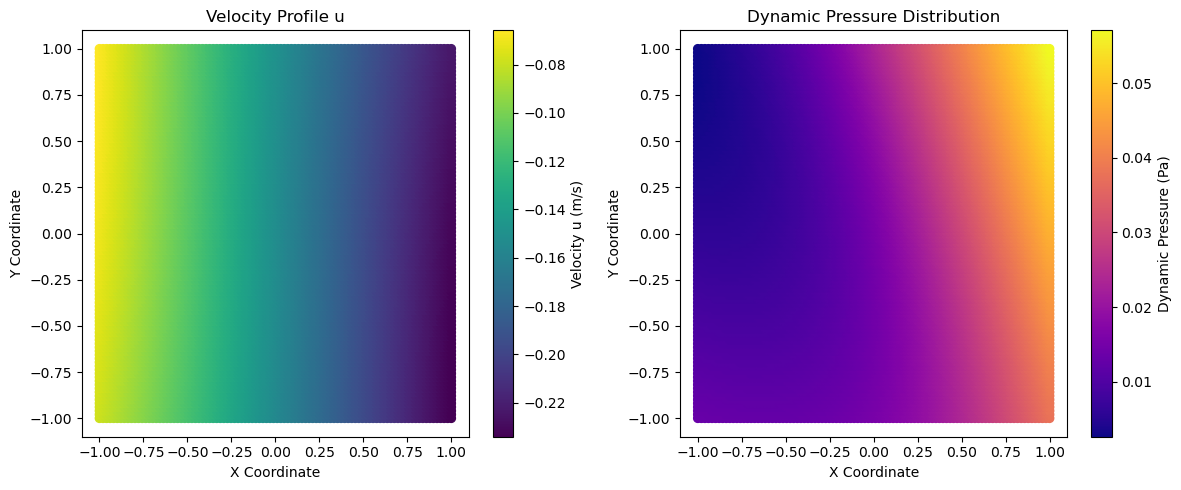

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(X_flat, Y_flat, c=predicted_u.numpy(), cmap='viridis')
plt.colorbar(label='Velocity u (m/s)')
plt.title('Velocity Profile u')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

plt.subplot(1, 2, 2)
plt.scatter(X_flat, Y_flat, c=dynamic_pressure.numpy(), cmap='plasma')
plt.colorbar(label='Dynamic Pressure (Pa)')
plt.title('Dynamic Pressure Distribution')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

plt.tight_layout()
plt.show()